<a href="https://colab.research.google.com/github/Lidorc91/KWS-Project/blob/main/KWS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive Folder
https://drive.google.com/drive/folders/1_WjZ7-oYJzy7k7mfw4Nj2bNj1KcWy3ok?usp=drive_link

###**Installations**

In [ ]:
#Dont show output
%%capture
! pip install pydub
! pip install tensorflow_io
! pip install tensorflow_datasets
! pip install tensorflow
! pip install librosa
! pip install keras-tuner

**Imports**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pickle
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import librosa
from tensorflow.keras.optimizers import Adam
import glob
import os

drive.mount('/content/drive')

Mounted at /content/drive


### Download Dataset

In [ ]:
# load a specific version of the "Speech Commands" dataset from
#TensorFlow Datasets (TFDS) and to access its training, validation, and test splits
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
validation = ds['validation']
test = ds['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyboardInterrupt: 

Info

In [ ]:
#load data set info
info = tfds.builder(f'speech_commands:0.0.3').info

In [ ]:
info

tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='https://arxiv.or

Extract Labels

In [ ]:
# get the list of labels
labels = info.features['label'].names
# get the number of labels
num_labels = info.features['label'].num_classes
# print the labels with their corresponding index
for i, label in enumerate(labels):
    print(f'{i}: {label}')

0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


#### Dataset Variable Definition

In [ ]:
# get the number of examples in the train, validation and test sets
num_train = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples
num_train, num_validation, num_test

(85511, 10102, 4890)

### Preprocess

In [ ]:
# map dataset to (audio, label)
train_labeled = train.map(lambda x: (x['audio'], x['label']))
validation_labeled = validation.map(lambda x: (x['audio'], x['label']))
test_labeled = test.map(lambda x: (x['audio'], x['label']))

In [ ]:
# Constants
SAMPLE_RATE = 16000
DURATION = 1  # 1 second
NUM_MFCC = 13  # number of Mel-Frequency Cepstral Coefficients (MFCCs) to be extracted from each audio clip.

In [ ]:
def preprocess(audio_labeled):
  Processed_Melspectograms = []
  labels = []
  for audio in audio_labeled:
    #Transform to tensor
    raw_audio_tensor = audio[0]
    tensor = tf.cast(raw_audio_tensor, tf.float32)
    #Trim
    position = tfio.audio.trim(tensor, axis=0, epsilon=0.05)
    start = position[0]
    stop = position[1]
    processed = tensor[start:stop] # Processed product
    #Padding
    padded_processed_audio = tf.pad(processed, paddings=[[0, SAMPLE_RATE - tf.shape(processed)[0]]], mode='CONSTANT', constant_values=0)
    #Convert to Spectogram
    padded_spectrogram = tfio.audio.spectrogram(padded_processed_audio, nfft=512, window=512, stride=256) #Processed Spectogram
    mel_spectrogram = tfio.audio.melscale(padded_spectrogram, rate=16000, mels=128, fmin=0, fmax=8000) #Mel-Spectogram
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80) #db-scaled Mel-Spectogram
    #Add Spectogram to list
    Processed_Melspectograms.append(dbscale_mel_spectrogram)
    labels.append(audio[1].numpy())
  return Processed_Melspectograms, labels

In [ ]:
train_Processed_Melspectograms, train_labels = preprocess(train_labeled)
test_Processed_Melspectograms, test_labels = preprocess(test_labeled)
validation_Processed_Melspectograms, validation_labels = preprocess(validation_labeled)

####Save Preprocessed datasets

In [ ]:
# save to file
# Specify the file path in your Google Drive
file_path_train = '/content/drive/My Drive/Colab Notebooks/train_Processed_Melspectograms.pkl'
file_path_test = '/content/drive/My Drive/Colab Notebooks/test_Processed_Melspectograms.pkl'
file_path_validation = '/content/drive/My Drive/Colab Notebooks/validation_Processed_Melspectograms.pkl'
file_path_labels = '/content/drive/My Drive/Colab Notebooks/labels.pkl'

# Save the list of tuples to file
with open(file_path_labels, 'wb') as f:
    pickle.dump(labels, f)

train_Processed_Melspectograms, train_labels = preprocess(train_labeled)
with open(file_path_train, 'wb') as f:
    pickle.dump((train_Processed_Melspectograms, train_labels), f)

test_Processed_Melspectograms, test_labels = preprocess(test_labeled)
with open(file_path_test, 'wb') as f:
    pickle.dump((test_Processed_Melspectograms, test_labels), f)

validation_Processed_Melspectograms, validation_labels = preprocess(validation_labeled)
with open(file_path_validation, 'wb') as f:
    pickle.dump((validation_Processed_Melspectograms, validation_labels), f)

####Load Saved Preprocessed Datasets

In [ ]:
# load all data

# Specify the file path in your Google Drive
file_path_train = '/content/drive/My Drive/Colab_Notebooks/train_Processed_Melspectograms.pkl'
file_path_test = '/content/drive/My Drive/Colab_Notebooks/test_Processed_Melspectograms.pkl'
file_path_validation = '/content/drive/My Drive/Colab_Notebooks/validation_Processed_Melspectograms.pkl'
file_path_labels = '/content/drive/My Drive/Colab_Notebooks/labels.pkl'

# Load the list of tuples from file
with open(file_path_train, 'rb') as f:
    train_Processed_Melspectograms, train_labels  = pickle.load(f)
with open(file_path_test, 'rb') as f:
    test_Processed_Melspectograms, test_labels  = pickle.load(f)
with open(file_path_validation, 'rb') as f:
    validation_Processed_Melspectograms, validation_labels  = pickle.load(f)
with open(file_path_labels, 'rb') as f:
    labels = pickle.load(f)

###Scale datasets

In [ ]:
X_train = np.array(train_Processed_Melspectograms) # mel spectogram
Y_train = np.array(train_labels) # command label

In [ ]:
x_val = np.array(validation_Processed_Melspectograms) # mel spectogram
val_labels = np.array(validation_labels) # command label

In [ ]:
x_test = np.array(test_Processed_Melspectograms) # mel spectogram
test_labels = np.array(test_labels) # command label

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train = X_train.reshape(-1, 63*128)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = X_train.reshape(-1, 63, 128)

In [ ]:
x_val = x_val.reshape(-1, 63*128)
scaler.fit(x_val)

x_val = scaler.transform(x_val)
x_val = x_val.reshape(-1, 63, 128)

In [ ]:
x_test = x_test.reshape(-1, 63*128)
scaler.fit(x_test)

x_test = scaler.transform(x_test)
x_test = x_test.reshape(-1, 63, 128)

####Save scaled datasets

In [ ]:
file_path_train = '/content/drive/My Drive/Colab_Notebooks/x_train_scaled.pkl'

# Save the scaled x train
with open(file_path_train, 'wb') as f:
    pickle.dump((X_train, train_labels), f)

In [ ]:
# Save the scaled validation
file_path_val_scaled = '/content/drive/My Drive/Colab_Notebooks/x_val_scaled.pkl'

with open(file_path_train, 'wb') as f:
    pickle.dump((x_val, val_labels), f)

In [ ]:
# Save the scaled test

file_path_test_scaled = '/content/drive/My Drive/Colab_Notebooks/test_scaled.pkl'
with open(file_path_train, 'wb') as f:
    pickle.dump((x_test, test_labels), f)

####Load scaled datasets

In [ ]:
# Load train data
file_path_x_train = '/content/drive/My Drive/Colab_Notebooks/x_train_scaled.pkl'

with open(file_path_x_train, 'rb') as f:
    X_train, train_labels = pickle.load(f)
    Y_train = np.array(train_labels) # command label

In [ ]:
# load validation data
file_path_val_scaled = '/content/drive/My Drive/Colab_Notebooks/x_val_scaled.pkl'

with open(file_path_val_scaled, 'rb') as f:
    x_val, y_val = pickle.load(f)

In [ ]:
# load test data
file_path_test_scaled = '/content/drive/My Drive/Colab_Notebooks/test_scaled.pkl'

with open(file_path_test_scaled, 'rb') as f:
    x_test, y_test = pickle.load(f)

In [ ]:
#load labels
file_path_labels = '/content/drive/My Drive/Colab_Notebooks/labels.pkl'

with open(file_path_labels, 'rb') as f:
    labels = pickle.load(f)

#*Model train*

##**Model definition**

In [ ]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(128, (7, 7), activation='relu',  input_shape=(63, 128, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Dropout

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Dropout

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))  # Dropout

model.add(layers.Flatten())

model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))

initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 57, 122, 128)        │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 57, 122, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 57, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 57, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 12, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 24, 64)           │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 24, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 12, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 12, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 2, 10, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 10, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           7,692 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,812 (1.51 MB)

 Trainable params: 396,044 (1.51 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Define the EarlyStopping callback and model save
checkpoint_filepath = '/content/drive/My Drive/Colab_Notebooks/models/beny_checkpoint_model.keras'

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy', depending on what you want to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)
mdlcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor="val_loss", save_best_only=True
)

##Run Model

In [ ]:
#running on X train with validation
history = model.fit(X_train, Y_train, batch_size=384, epochs=60, verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop, mdlcheckpoint])
history_dict = history.history

#Run on test
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/60
 76/223 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.5403 - loss: 1.8405

KeyboardInterrupt: 

Save model

In [ ]:
path_model = '/content/drive/My Drive/Colab_Notebooks/models/model_beny_87.keras'
path_history = '/content/drive/My Drive/Colab_Notebooks/models/history_87.pkl'

with open(path_history, 'wb') as f:
    pickle.dump(history.history, f)
model.save(path_model)

Load model

In [ ]:
path_model = '/content/drive/My Drive/Colab_Notebooks/models/model_beny_87.keras'
path_history = '/content/drive/My Drive/Colab_Notebooks/models/history_87.pkl'

model = tf.keras.models.load_model(path_model)
with open(path_history, 'rb') as f:
    history_dict = pickle.load(f)

Plot Summary graph

<Axes: >

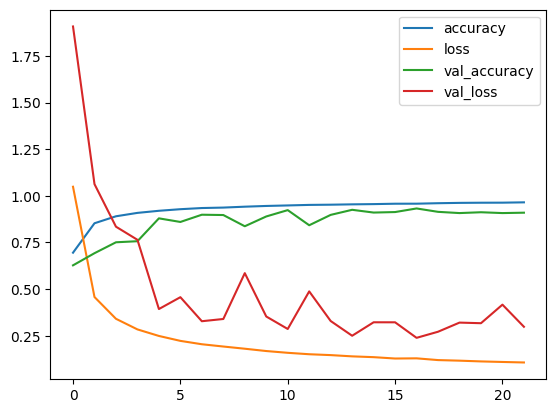

In [ ]:
Losses = pd.DataFrame(history_dict)
Losses.plot()

##Run on test

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8742 - loss: 0.5153
Test accuracy: 0.878118634223938
